In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Definitions

In [2]:
def get_counts(values: np.array, y_scales: np.array, boxes=10):
    step = (y_scales[1] - y_scales[0]) / boxes
    division = [y_scales[0] + step * i for i in range(boxes + 1)]
    
    m = values.repeat(boxes).reshape(values.shape[0], -1)
    counts = np.logical_and(m > [division[i] for i in range(boxes)], m <= [division[i + 1] for i in range(boxes)])
    
    return counts.sum(axis=0) / counts.sum()

def compute_rectangles(counts, ref_x, maxx, y_scales: np.ndarray):
    boxes = len(counts)
    max_count = counts.max()
    
    # height of a box
    height = (y_scales[1] - y_scales[0]) / boxes
    
    # compute x, y coordinates of every box
    x = [
        [ref_x, ref_x + counts[i] * maxx / max_count, ref_x + counts[i] * maxx / max_count, ref_x]
        for i in range(boxes)
    ]
    y = [
        [y_scales[0] + i * height, y_scales[0] + i * height, y_scales[0] + (i+1) * height, y_scales[0] + (i+1) * height]
        for i in range(boxes)
    ]
    
    # expand list of lists
    x = [i for k in x for i in k]
    y = [i for k in y for i in k]
    
    return x, y

In [3]:
def compute_rescaled(y: np.ndarray, y_scales: np.ndarray):
    """
    Computes rescaled y axes, for all except the first axis

    Parameters:
        y: the matrix of m x n, where m is the number of samples and n is their feature dimension

    Returns:
        Recomputed y for all columns except the first one
    """

    # rescale all but the first column
    yr = (y[:, 1:] - y_scales[1:, 0]) / (y_scales[1:, 1] - y_scales[1:, 0]) * \
        (y_scales[:-1, 1] - y_scales[:-1, 0]) + y_scales[:-1, 0]

    # first column does not change, so add it
    yr = np.concatenate([y[:, 0].reshape(-1, 1), yr], axis=1)

    return yr


def parallel_plot(y: np.ndarray, y_scales: np.ndarray=None, alpha=0.4, maxx=0.2, boxes=20, per_class=False):
    ndims = y.shape[1]

    # create x list
    x = range(1, ndims + 1)

    # create figure
    fig, ax = plt.subplots(1, ndims - 1, sharey=False, figsize=(12, 7))

    # filter first class examples
    class_1 = list(set(y[:, -1]))[0]
    class_2 = list(set(y[:, -1]))[1]

    # compute scales (feature intervals)
    if y_scales is None:
        y_scales = np.stack([y.min(axis=0), y.max(axis=0)], axis=0).T

    # compute rescaled coordinate
    yr = compute_rescaled(y, y_scales)
    yr = (y[:, 1:] - y_scales[1:, 0]) / (y_scales[1:, 1] - y_scales[1:, 0]) * (y_scales[:-1, 1] - y_scales[:-1, 0]) + y_scales[:-1, 0]
    yr = np.concatenate([y[:, 0].reshape(-1, 1), yr], axis=1)

    # plot all samples
    for i in range(y.shape[0]):
        color = 'r-' if y[i][-1] == class_1 else 'b-'

        # plot the line from original point to the rescaled point
        for j in range(ndims - 1):
            ax[j].plot(x[j:j+2], [y[i, j], yr[i, j+1]], color, alpha=alpha, lw=1.)
    

    # set y scales
    for j in range(ndims - 1):
        ax[j].set_ylim([y_scales[j, 0], y_scales[j, 1]])

    # set last axis as twin, but with last scale
    ax_la = ax[-1].twinx()
    ax_la.set_ylim([y_scales[-1, 0], y_scales[-1, 1]])

    # set ticks
    for j in range(ndims - 1):
        ax[j].set_yticks(np.linspace(y_scales[j, 0], y_scales[j, 1], 10))
    ax_la.set_yticks(np.linspace(y_scales[-1, 0], y_scales[-1, 1], 2))

    # now zoom in each of the subplots
    for j in range(ndims - 1):
        ax[j].set_xlim([x[j], x[j+1]])

    features = ['1st', '2nd', '3rd']
    for j in range(ndims - 2):
        ax[j].set_xticks([x[j]])
        ax[j].set_xticklabels([f'{features[j]} feature' if j < 3 else f'{j+1}th feature'])
    
    j = ndims - 2
    ax[j].set_xticks(x[-2:])
    ax[j].set_xticklabels([f'{features[j]} feature' if j < 3 else f'{j+1}th feature', 'class'])
    

    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    # show the distribution rectangles
    if boxes > 0:
        if not per_class:
            for j in range(ndims - 1):
                rectangles = compute_rectangles(
                    get_counts(y[:, j], y_scales[j], boxes=boxes),
                    ref_x=x[j],
                    maxx=maxx,
                    y_scales=y_scales[j]
                )
                ax[j].plot(rectangles[0], rectangles[1], 'k-', lw=3)
        else: # per_class rectangles
            for c in [class_1, class_2]:
                y_class = y[y[:, -1] == c]
                for j in range(ndims - 1):
                    rectangles = compute_rectangles(
                        get_counts(y_class[:, j], y_scales[j], boxes=boxes),
                        ref_x=x[j],
                        maxx=maxx,
                        y_scales=y_scales[j]
                    )
                    ax[j].plot(rectangles[0], rectangles[1], 'r-' if c == class_1 else 'b-', lw=3)

    plt.show()

# Circles

In [4]:
data = torch.load('./data/circles.pt')
print(f"x shape: {data['x'].shape}")
print(f"y shape: {data['y'].shape}")

x shape: torch.Size([99900, 2])
y shape: torch.Size([99900])


In [5]:
y = np.concatenate([data['x'].numpy(), data['y'].numpy().reshape(-1, 1)], axis=1)

In [6]:
y_scales = np.array([
    [0, 1.0],
    [0, 1.0],
    [-1, 1]
])

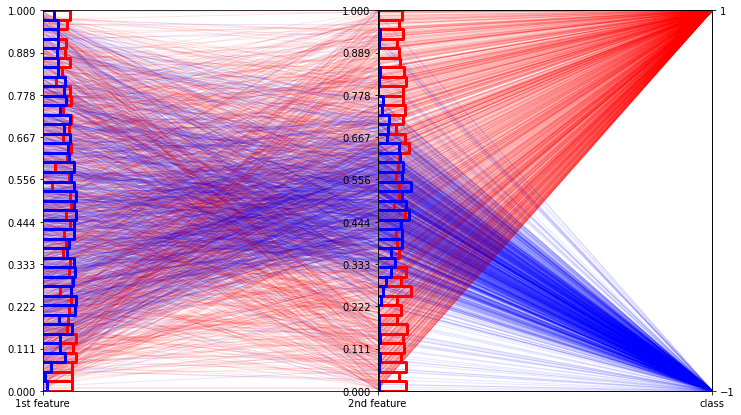

In [7]:
# representation of the entire dataset (2000 random samples from it)
parallel_plot(
    y[np.random.choice(range(y.shape[0]), 2000, replace=False)],
    y_scales=y_scales, alpha=0.1, maxx=0.1, boxes=40, per_class=True
)

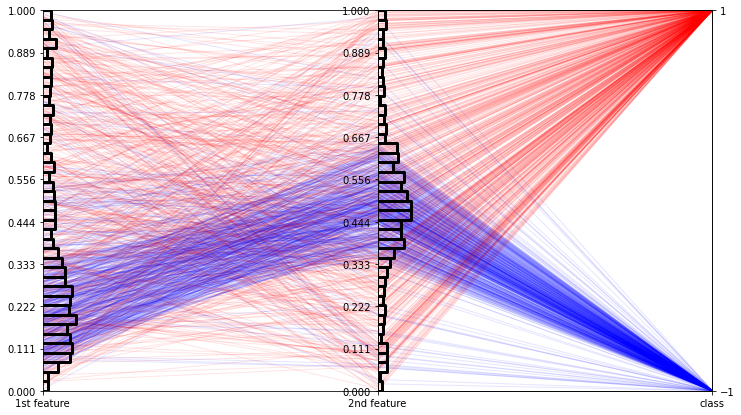

In [8]:
# fist 1000 samples
parallel_plot(y[:1000], y_scales=y_scales, alpha=0.1, maxx=0.1, boxes=40, per_class=False)

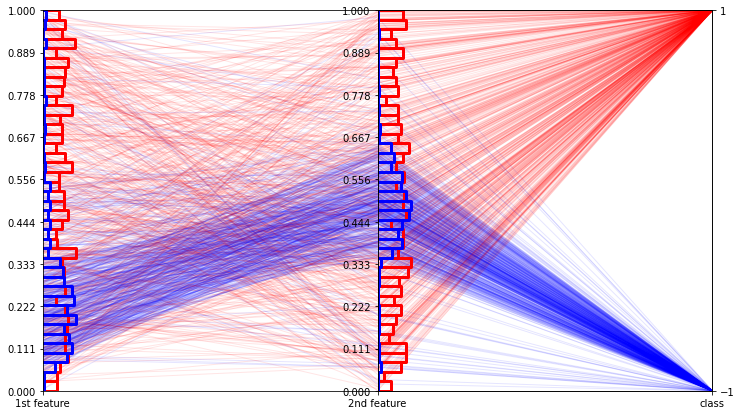

In [9]:
# fist 1000 samples, per class
parallel_plot(y[:1000], y_scales=y_scales, alpha=0.1, maxx=0.1, boxes=40, per_class=True)

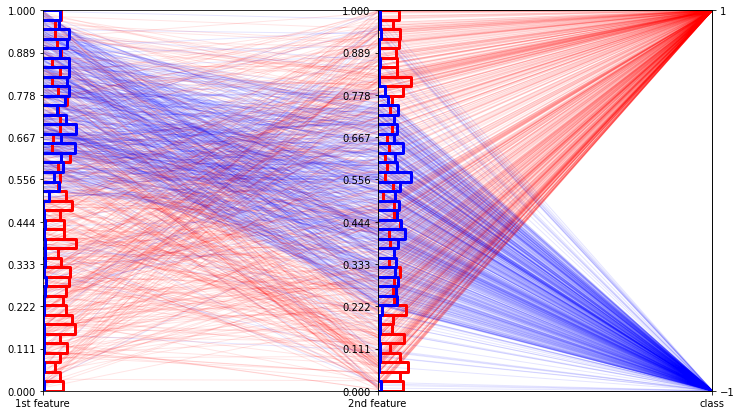

In [10]:
# last 1000 samples
parallel_plot(y[-1000:], y_scales=y_scales, alpha=0.1, maxx=0.1, boxes=40, per_class=True)

In [11]:
def parallel_drift(
    y: np.ndarray, y_scales: np.ndarray=None, 
    epoch_width=1000, epoch_step=1000, steps=10,
    alpha=0.4, maxx=0.2, boxes=20, per_class=False
):
    ndims = y.shape[1]

    # create x list
    x = range(1, ndims + 1)

    # create figure
    fig, ax = plt.subplots(1, ndims - 1, sharey=False, figsize=(12, 7))

    # filter first class examples
    class_1 = list(set(y[:, -1]))[0]
    class_2 = list(set(y[:, -1]))[1]

    # compute scales (feature intervals)
    if y_scales is None:
        y_scales = np.stack([y.min(axis=0), y.max(axis=0)], axis=0).T   

    # set y scales
    for j in range(ndims - 1):
        ax[j].set_ylim([y_scales[j, 0], y_scales[j, 1]])

    # set last axis as twin, but with last scale
    #ax_la = ax[1].twinx()
    #ax_la.set_ylim([y_scales[-1, 0], y_scales[-1, 1]])

    # set ticks
    for j in range(ndims - 1):
        ax[j].set_yticks(np.linspace(y_scales[j, 0], y_scales[j, 1], 10))
    #ax_la.set_yticks([y_scales[-1, 0], y_scales[-1, 1]])

    # now zoom in each of the subplots
    for j in range(ndims - 1):
        ax[j].set_xlim([x[j], x[j+1]])

    features = ['1st', '2nd', '3rd']
    for j in range(ndims - 2):
        ax[j].set_xticks([x[j]])
        ax[j].set_xticklabels([f'{features[j]} feature' if j < 3 else f'{j+1}th feature'])
    ax[ndims - 2].set_xticks(x[-2:])
    j = ndims - 2
    ax[j].set_xticklabels([f'{features[j]} feature' if j < 3 else f'{j+1}th feature', ''])

    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    # show the distribution rectangles
    if not per_class:
        means_steps = []
        for step in range(steps):
            y_step = y[step * epoch_step : (step + 1) * epoch_step]
        
            means_dims = []
            for j in range(ndims - 1):
                rectangles = compute_rectangles(
                    get_counts(y_step[:, j], y_scales[j], boxes=boxes),
                    ref_x=x[j] + step * maxx,
                    maxx=maxx * 0.7,
                    y_scales=y_scales[j]
                )
                
                # put distribution
                ax[j].plot(rectangles[0], rectangles[1], 'k-', lw=1)
                ax[j].plot([x[j] + step * maxx, x[j] + step * maxx], [y_scales[j, 0], y_scales[j, 1]], 'k-', lw=0.5)
                
                # x axis markers
                ax[j].annotate(
                    step, xy=(x[j] + step * maxx, 0.01), xytext=(x[j] + step * maxx, -0.07),
                    color='k', weight='bold', fontsize=9
                )
                
                # add to means
                means_dims.append(y_step[:, j].mean())
            means_steps.append(means_dims)
            
        # plot drift
        for j in range(ndims - 1):
            ax[j].plot(
                [x[j] + step * maxx for step in range(steps)],
                [means_steps[step][j] for step in range(steps)],
                'ok-'
            )
                
    else: # per_class rectangles
        means_steps = []
        for step in range(steps):
            y_step = y[step * epoch_step : (step + 1) * epoch_step]
        
            means_classes = []
            for c in [class_1, class_2]:
                y_class = y_step[y_step[:, -1] == c]
                
                means_dims = []
                for j in range(ndims - 1):
                    rectangles = compute_rectangles(
                        get_counts(y_class[:, j], y_scales[j], boxes=boxes),
                        ref_x=x[j] + step * maxx,
                        maxx=maxx * 0.7,
                        y_scales=y_scales[j]
                    )

                    # put distribution
                    ax[j].plot(rectangles[0], rectangles[1], 'r-' if c == class_1 else 'b-', lw=1)
                    ax[j].plot([x[j] + step * maxx, x[j] + step * maxx], [y_scales[j, 0], y_scales[j, 1]], 'k-', lw=0.5)
                    
                    # x axis markers
                    ax[j].annotate(
                        step, xy=(x[j] + step * maxx, 0.01), xytext=(x[j] + step * maxx, -0.07),
                        color='k', weight='bold', fontsize=9
                    )

                    # add to means
                    means_dims.append(y_class[:, j].mean())
                means_classes.append(means_dims)
            means_steps.append(means_classes)
            
        # plot drift
        for c in range(len([class_1, class_2])):
            for j in range(ndims - 1):
                ax[j].plot(
                    [x[j] + step * maxx for step in range(steps)],
                    [means_steps[step][c][j] for step in range(steps)],
                    'or-' if c == class_1 else 'ob-'
                )
        ax[-1].legend([f'class {i}' for i in [class_1, class_2]])

    plt.show()

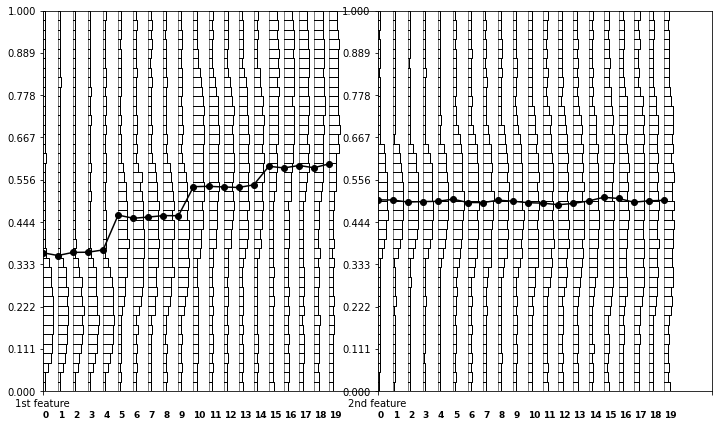

In [12]:
parallel_drift(
    y, y_scales=y_scales,
    epoch_width=5000, epoch_step=5000, steps=20,
    alpha=0.1, maxx=0.045, boxes=40, per_class=False
)

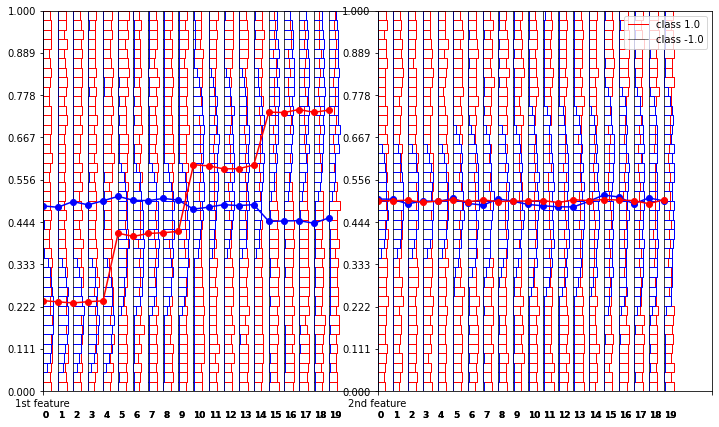

In [13]:
parallel_drift(
    y, y_scales=y_scales,
    epoch_width=5000, epoch_step=5000, steps=20,
    alpha=0.1, maxx=0.045, boxes=40, per_class=True
)

# Electricity

In [14]:
data = torch.load('./data/electricity.pt')
print(f"x shape: {data['x'].shape}")
print(f"y shape: {data['y'].shape}")

x shape: torch.Size([45312, 12])
y shape: torch.Size([45312])


In [15]:
z = np.concatenate([data['x'].numpy(), data['y'].numpy().reshape(-1, 1)], axis=1)

In [16]:
y = z[:, [0, 3, 4, 5, -1]]
y_scales = np.array([a for a in zip(y.min(axis=0), y.max(axis=0))])

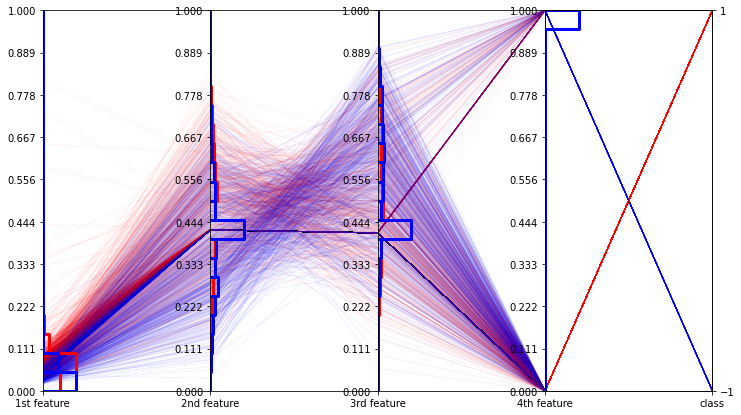

In [17]:
# representation of the entire dataset (2000 random samples from it)
parallel_plot(
    y[np.random.choice(range(y.shape[0]), 2000, replace=False)],
    y_scales=y_scales, alpha=0.05, maxx=0.2, boxes=20, per_class=True
)

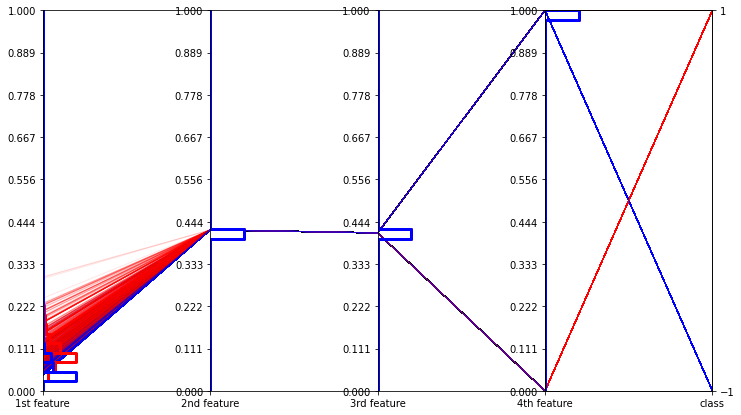

In [18]:
# fist 5000 samples, per class
parallel_plot(y[:5000], y_scales=y_scales, alpha=0.1, maxx=0.2, boxes=40, per_class=True)

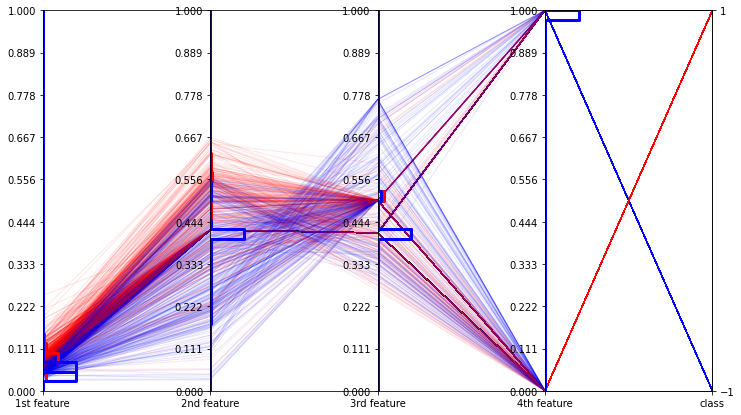

In [19]:
parallel_plot(y[15000:18000], y_scales=y_scales, alpha=0.1, maxx=0.2, boxes=40, per_class=True)

# Covertype

In [20]:
data = torch.load('./data/covertype.pt')
print(f"x shape: {data['x'].shape}")
print(f"y shape: {data['y'].shape}")

x shape: torch.Size([489449, 54])
y shape: torch.Size([489449])


In [21]:
z = np.concatenate([data['x'].numpy(), data['y'].numpy().reshape(-1, 1)], axis=1)

In [22]:
y = z[:, [0, 1, 2, 3, 5, 9, -1]]
y_scales = np.array([a for a in zip(y.min(axis=0), y.max(axis=0))])

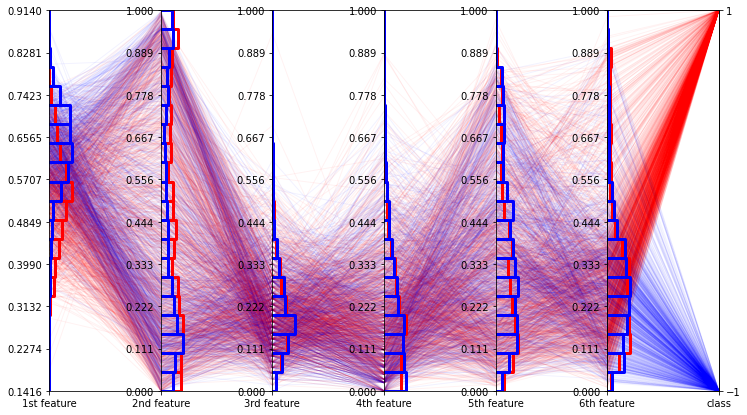

In [23]:
# representation of the entire dataset (2000 random samples from it)
parallel_plot(
    y[np.random.choice(range(y.shape[0]), 2000, replace=False)],
    y_scales=y_scales, alpha=0.05, maxx=0.2, boxes=20, per_class=True
)

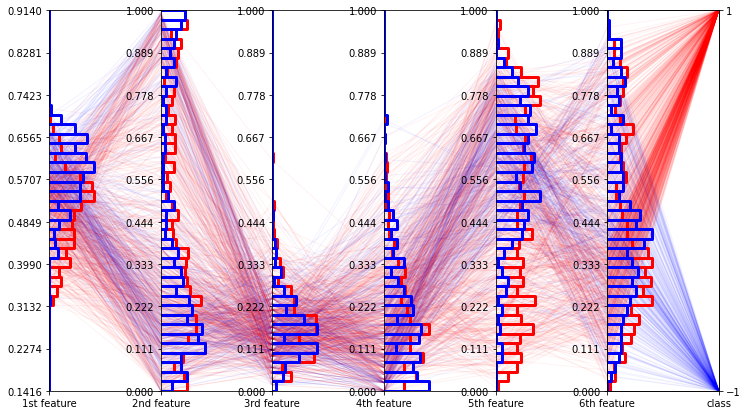

In [24]:
# representation of the entire dataset (2000 random samples from it)
parallel_plot(
    y[:1000],
    y_scales=y_scales, alpha=0.05, maxx=0.4, boxes=40, per_class=True
)

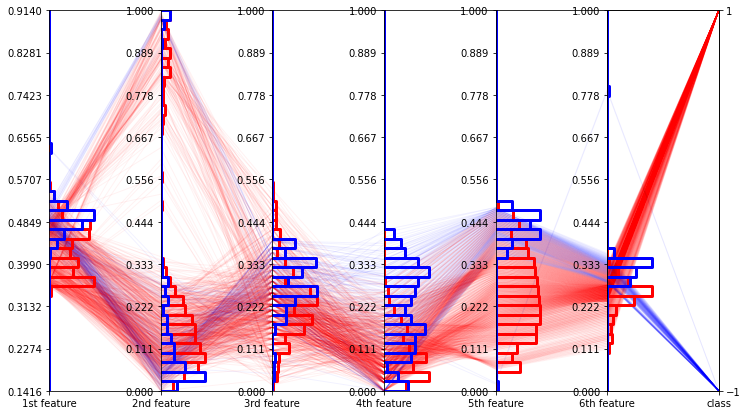

In [25]:
parallel_plot(
    y[-1000:],
    y_scales=y_scales, alpha=0.05, maxx=0.4, boxes=40, per_class=True
)

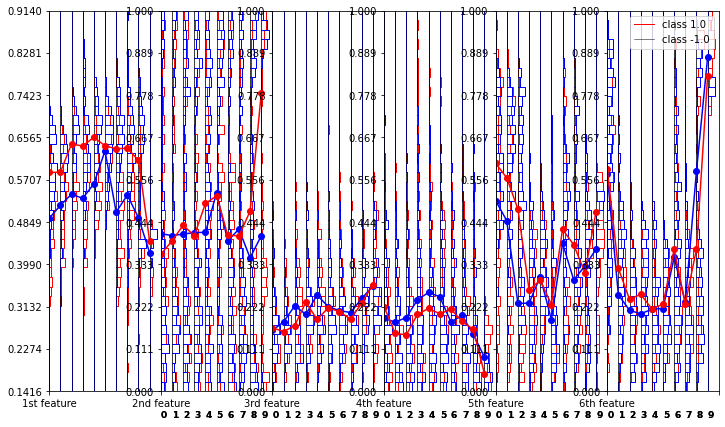

In [26]:
# drift representation in the entire dataset
parallel_drift(
    y[:5000], y_scales=y_scales,
    epoch_width=500, epoch_step=500, steps=10,
    alpha=0.09, maxx=0.1, boxes=40, per_class=True
)

## Showing drift in SINE1

In [27]:
data = torch.load('./data/sine1.pt')
print(f"x shape: {data['x'].shape}")
print(f"y shape: {data['y'].shape}")

x shape: torch.Size([100000, 2])
y shape: torch.Size([100000])


In [28]:
z = np.concatenate([data['x'].numpy(), data['y'].numpy().reshape(-1, 1)], axis=1)

In [29]:
y = z[:, :]
y_scales = np.array([a for a in zip(y.min(axis=0), y.max(axis=0))])

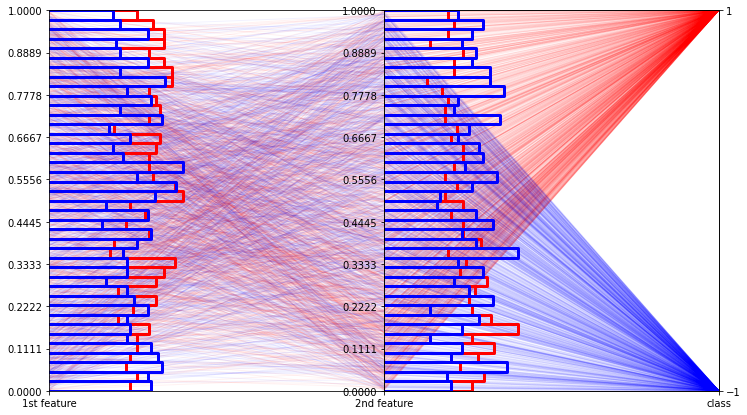

In [30]:
# representation of the entire dataset (2000 random samples from it)
parallel_plot(
    y[np.random.choice(range(y.shape[0]), 2000, replace=False)],
    y_scales=y_scales, alpha=0.05, maxx=0.4, boxes=40, per_class=True
)

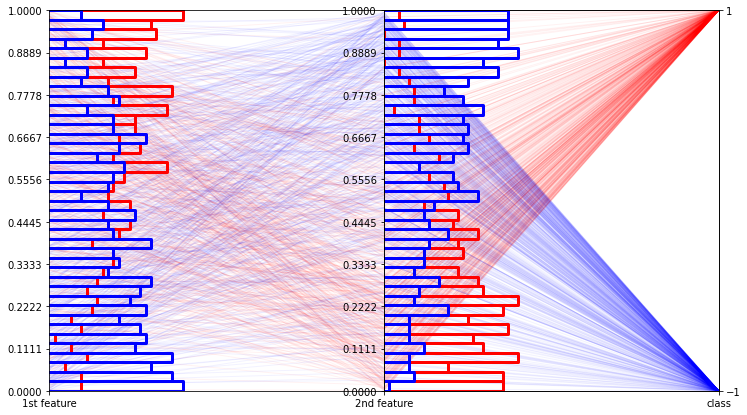

In [31]:
# representation of 1000 samples, before 20000
parallel_plot(
    y[19000:20000],
    y_scales=y_scales, alpha=0.05, maxx=0.4, boxes=40, per_class=True
)

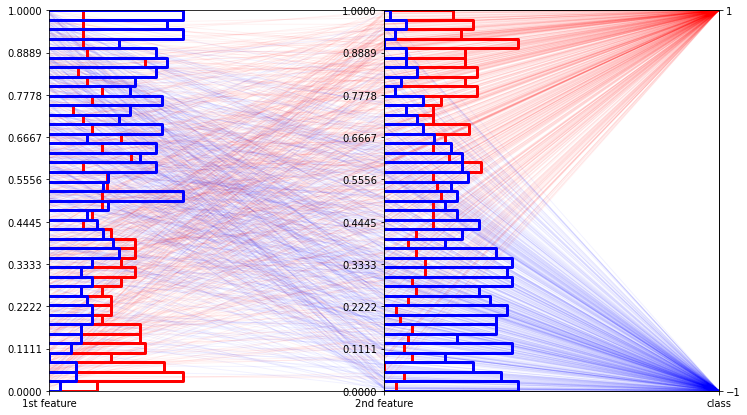

In [32]:
# representation of 1000 samples, after 20000
parallel_plot(
    y[20000:21000],
    y_scales=y_scales, alpha=0.05, maxx=0.4, boxes=40, per_class=True
)

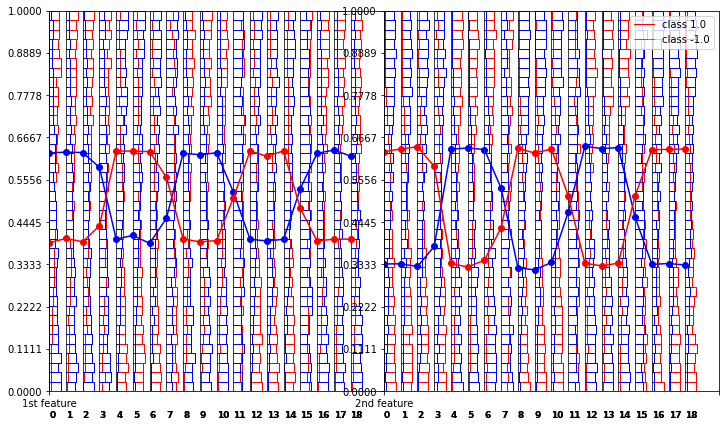

In [33]:
# drift representation in the entire dataset
parallel_drift(
    y, y_scales=y_scales,
    epoch_width=5200, epoch_step=5200, steps=19,
    alpha=0.1, maxx=0.05, boxes=40, per_class=True
)

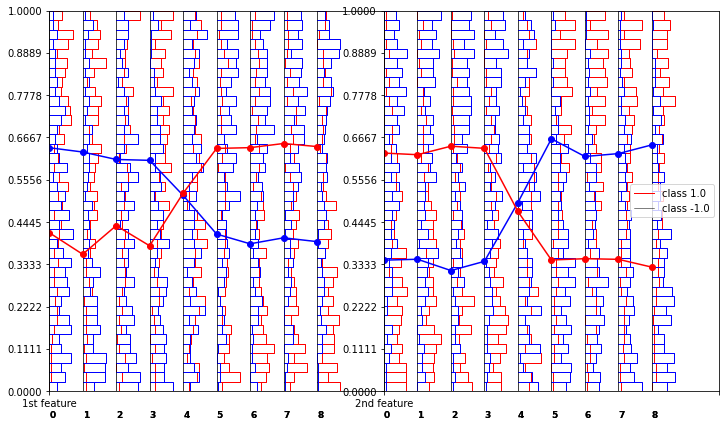

In [34]:
# representation of 500 steps, the drift occurs inside one of the middle of the 500 samples shifting window
parallel_drift(
    y[20045-2250:20045+2250], y_scales=y_scales,
    epoch_width=500, epoch_step=500, steps=9,
    alpha=0.1, maxx=0.1, boxes=40, per_class=True
)

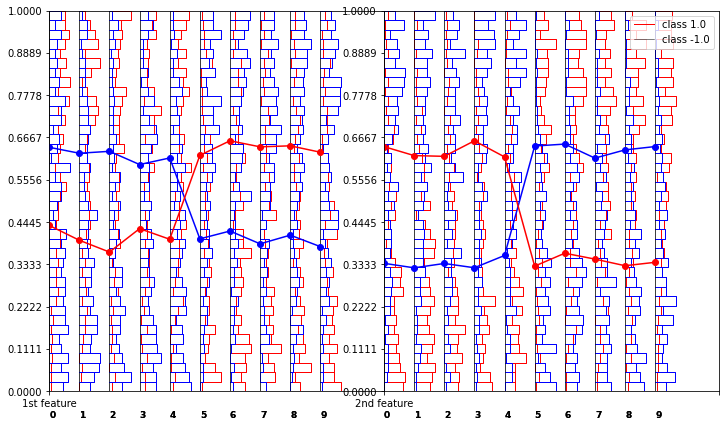

In [35]:
# representation of 500 steps, the drift occurs as the window empties
parallel_drift(
    y[20045-2500:20045+2500], y_scales=y_scales,
    epoch_width=500, epoch_step=500, steps=10,
    alpha=0.1, maxx=0.09, boxes=40, per_class=True
)